<a href="https://colab.research.google.com/github/Farah-Saleem91/Car-Insurance-Data/blob/main/car_insurance_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


1.What is the target? (You are required to complete a classification task for this project)
**our targest is Outcome**

2.What does one row represent? (A person? A business? An event? A product?)

**person**

3.How many features does the data have?

**19**

4.How many rows are in the dataset?

**10000**

5.What opportunities exist for dimensionality reduction or feature selection with this dataset?

6.What, if any, challenges do you foresee in cleaning, exploring, or modeling this dataset?

In [2]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns',100)
import missingno
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor # Import RandomForestRegressor
# Set pandas as the default output for sklearn
from sklearn import set_config
from sklearn.linear_model import LinearRegression
set_config(transform_output='pandas')

In [3]:
fpath='/content/drive/MyDrive/Car_Insurance_Claim.csv'

df = pd.read_csv(fpath)
df=df.set_index('ID')

df.head()

,AGE,GENDER,RACE,DRIVING_EXPERIENCE,EDUCATION,INCOME,CREDIT_SCORE,VEHICLE_OWNERSHIP,VEHICLE_YEAR,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,VEHICLE_TYPE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS,OUTCOME
ID,,,,,,,,,,,,,,,,,,
569520,65+,female,majority,0-9y,high school,upper class,0.629027,1.0,after 2015,0.0,1.0,10238,12000.0,sedan,0,0,0,0.0
750365,16-25,male,majority,0-9y,none,poverty,0.357757,0.0,before 2015,0.0,0.0,10238,16000.0,sedan,0,0,0,1.0
199901,16-25,female,majority,0-9y,high school,working class,0.493146,1.0,before 2015,0.0,0.0,10238,11000.0,sedan,0,0,0,0.0
478866,16-25,male,majority,0-9y,university,working class,0.206013,1.0,before 2015,0.0,1.0,32765,11000.0,sedan,0,0,0,0.0
731664,26-39,male,majority,10-19y,none,working class,0.388366,1.0,before 2015,0.0,0.0,32765,12000.0,sedan,2,0,1,1.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 569520 to 442696
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   AGE                  10000 non-null  object 
 1   GENDER               10000 non-null  object 
 2   RACE                 10000 non-null  object 
 3   DRIVING_EXPERIENCE   10000 non-null  object 
 4   EDUCATION            10000 non-null  object 
 5   INCOME               10000 non-null  object 
 6   CREDIT_SCORE         9018 non-null   float64
 7   VEHICLE_OWNERSHIP    10000 non-null  float64
 8   VEHICLE_YEAR         10000 non-null  object 
 9   MARRIED              10000 non-null  float64
 10  CHILDREN             10000 non-null  float64
 11  POSTAL_CODE          10000 non-null  int64  
 12  ANNUAL_MILEAGE       9043 non-null   float64
 13  VEHICLE_TYPE         10000 non-null  object 
 14  SPEEDING_VIOLATIONS  10000 non-null  int64  
 15  DUIS                 10000 non-null

In [5]:
df['AGE'].value_counts()

,count
AGE,
26-39,3063
40-64,2931
16-25,2016
65+,1990


#EDA functions

In [7]:
"""UNIVARIATE PLOTTING FUNCTIONS FOR EDA"""
# Add the print statements to the function
def explore_categorical(df, x, fillna = True, placeholder = 'MISSING',
                        figsize = (6,4), order = None):
  """Creates a seaborn countplot with the option to temporarily fill missing values
  Prints statements about null values, cardinality, and checks for
  constant/quasi-constant features.
  Source:{PASTE IN FINAL LESSON LINK}
  """
  # Make a copy of the dataframe and fillna
  temp_df = df.copy()
  # Before filling nulls, save null value counts and percent for printing
  null_count = temp_df[x].isna().sum()
  null_perc = null_count/len(temp_df)* 100
  # fillna with placeholder
  if fillna == True:
    temp_df[x] = temp_df[x].fillna(placeholder)
  # Create figure with desired figsize
  fig, ax = plt.subplots(figsize=figsize)
  # Plotting a count plot
  sns.countplot(data=temp_df, x=x, ax=ax, order=order)
  # Rotate Tick Labels for long names
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
  # Add a title with the feature name included
  ax.set_title(f"Column: {x}", fontweight='bold')

  # Fix layout and show plot (before print statements)
  fig.tight_layout()
  plt.show()

  # Print null value info
  print(f"- NaN's Found: {null_count} ({round(null_perc,2)}%)")
  # Print cardinality info
  nunique = temp_df[x].nunique()
  print(f"- Unique Values: {nunique}")
  # First find value counts of feature
  val_counts = temp_df[x].value_counts(dropna=False)
  # Define the most common value
  most_common_val = val_counts.index[0]
  # Define the frequency of the most common value
  freq = val_counts.values[0]
  # Calculate the percentage of the most common value
  perc_most_common = freq / len(temp_df) * 100
  # Print the results
  print(f"- Most common value: '{most_common_val}' occurs {freq} times ({round(perc_most_common,2)}%)")
  # print message if quasi-constant or constant (most common val more than 98% of data)
  if perc_most_common > 98:
    print(f"\n- [!] Warning: '{x}' is a constant or quasi-constant feature and should be dropped.")
  else:
    print("- Not constant or quasi-constant.")
  return fig, ax


# TO DO: add the new print statements from explore_categorical
def explore_numeric(df, x, figsize=(6,5) ):
  """Creates a seaborn histplot and boxplot with a share x-axis,
  Prints statements about null values, cardinality, and checks for
  constant/quasi-constant features.
  Source:{PASTE IN FINAL LESSON LINK}
  """

  ## Save null value counts and percent for printing
  null_count = df[x].isna().sum()
  null_perc = null_count/len(df)* 100


  ## Making our figure with gridspec for subplots
  gridspec = {'height_ratios':[0.7,0.3]}
  fig, axes = plt.subplots(nrows=2, figsize=figsize,
                           sharex=True, gridspec_kw=gridspec)
  # Histogram on Top
  sns.histplot(data=df, x=x, ax=axes[0])

  # Boxplot on Bottom
  sns.boxplot(data=df, x=x, ax=axes[1])

  ## Adding a title
  axes[0].set_title(f"Column: {x}", fontweight='bold')

  ## Adjusting subplots to best fill Figure
  fig.tight_layout()

  # Ensure plot is shown before message
  plt.show()


  # Print null value info
  print(f"- NaN's Found: {null_count} ({round(null_perc,2)}%)")
  # Print cardinality info
  nunique = df[x].nunique()
  print(f"- Unique Values: {nunique}")


  # Get the most most common value, its count as # and as %
  most_common_val_count = df[x].value_counts(dropna=False).head(1)
  most_common_val = most_common_val_count.index[0]
  freq = most_common_val_count.values[0]
  perc_most_common = freq / len(df) * 100

  print(f"- Most common value: '{most_common_val}' occurs {freq} times ({round(perc_most_common,2)}%)")

  # print message if quasi-constant or constant (most common val more than 98% of data)
  if perc_most_common > 98:
    print(f"\n- [!] Warning: '{x}' is a constant or quasi-constant feature and should be dropped.")
  else:
    print("- Not constant or quasi-constant.")
  return fig, axes


/tmp/ipython-input-1613442045.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


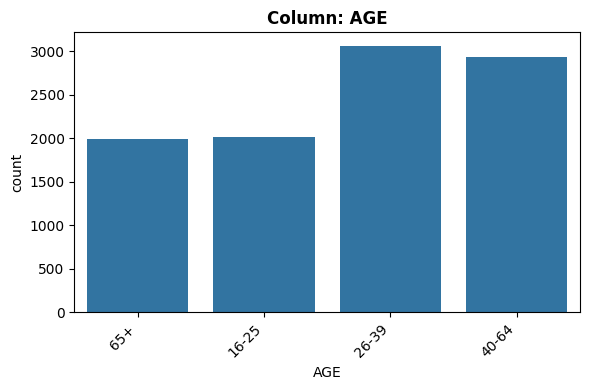

- NaN's Found: 0 (0.0%)
- Unique Values: 4
- Most common value: '26-39' occurs 3063 times (30.63%)
- Not constant or quasi-constant.


In [8]:
feature='AGE'
explore_categorical(df,feature);

In [9]:
df['GENDER'].value_counts()

,count
GENDER,
female,5010
male,4990


/tmp/ipython-input-1613442045.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


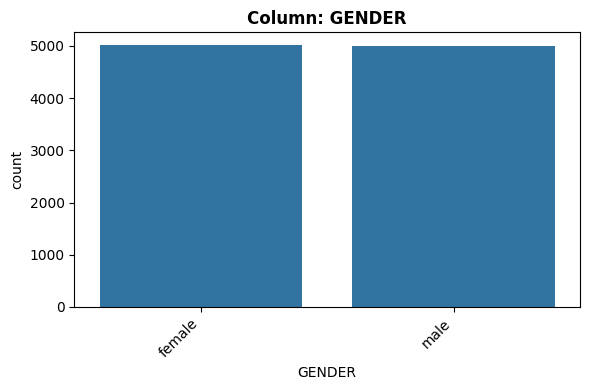

- NaN's Found: 0 (0.0%)
- Unique Values: 2
- Most common value: 'female' occurs 5010 times (50.1%)
- Not constant or quasi-constant.


In [10]:
feature='GENDER'
explore_categorical(df,feature);

In [ ]:
RACE                 10000 non-null  object
 3   DRIVING_EXPERIENCE   10000 non-null  object
 4   EDUCATION            10000 non-null  object
 5   INCOME               10000 non-null  object

In [11]:
df['RACE'].value_counts()

,count
RACE,
majority,9012
minority,988


/tmp/ipython-input-1613442045.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


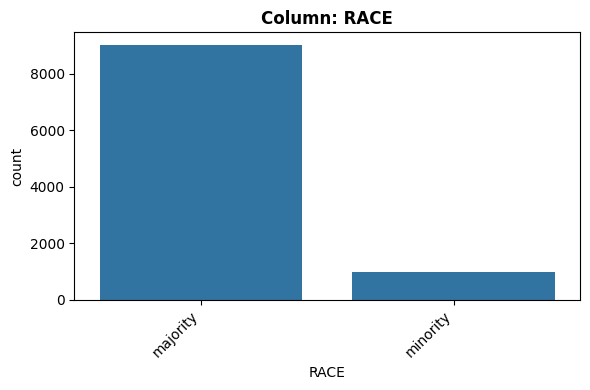

- NaN's Found: 0 (0.0%)
- Unique Values: 2
- Most common value: 'majority' occurs 9012 times (90.12%)
- Not constant or quasi-constant.


In [12]:
feature='RACE'
explore_categorical(df,feature);

In [13]:
df['DRIVING_EXPERIENCE'].value_counts()

,count
DRIVING_EXPERIENCE,
0-9y,3530
10-19y,3299
20-29y,2119
30y+,1052


/tmp/ipython-input-1613442045.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


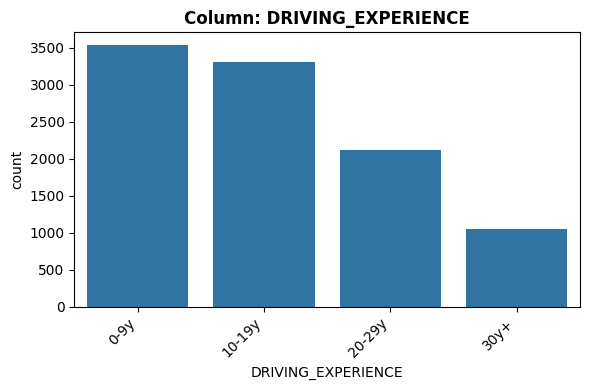

- NaN's Found: 0 (0.0%)
- Unique Values: 4
- Most common value: '0-9y' occurs 3530 times (35.3%)
- Not constant or quasi-constant.


In [14]:
feature='DRIVING_EXPERIENCE'
explore_categorical(df,feature);

In [16]:
df['EDUCATION'].value_counts()

,count
EDUCATION,
high school,4157
university,3928
none,1915


/tmp/ipython-input-1613442045.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


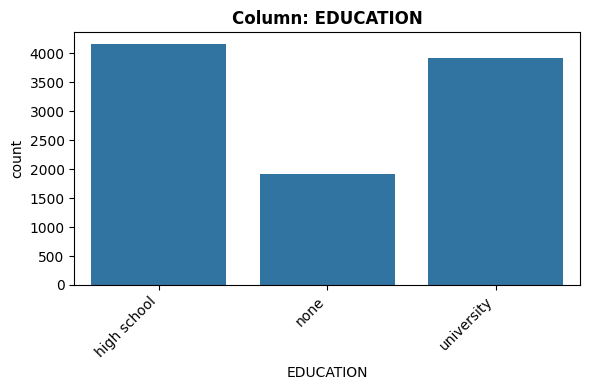

- NaN's Found: 0 (0.0%)
- Unique Values: 3
- Most common value: 'high school' occurs 4157 times (41.57%)
- Not constant or quasi-constant.


In [17]:
feature='EDUCATION'
explore_categorical(df,feature);

In [18]:
df['INCOME'].value_counts()

,count
INCOME,
upper class,4336
middle class,2138
poverty,1814
working class,1712


/tmp/ipython-input-1613442045.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


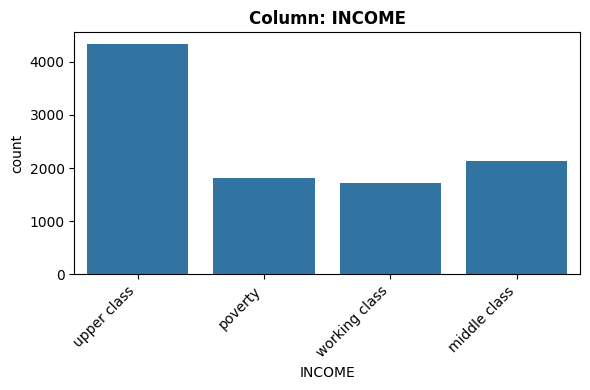

- NaN's Found: 0 (0.0%)
- Unique Values: 4
- Most common value: 'upper class' occurs 4336 times (43.36%)
- Not constant or quasi-constant.


In [19]:
feature='INCOME'
explore_categorical(df,feature);

In [20]:
df['VEHICLE_TYPE'].value_counts()

,count
VEHICLE_TYPE,
sedan,9523
sports car,477


/tmp/ipython-input-1613442045.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


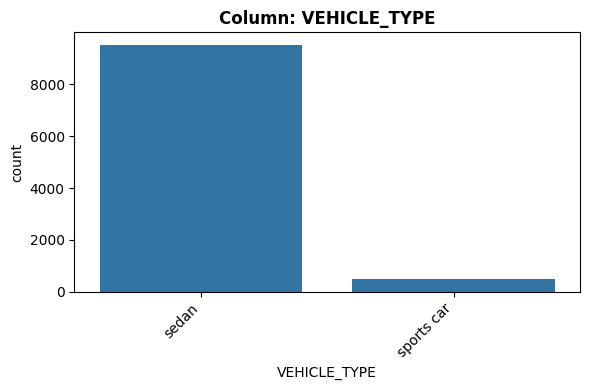

- NaN's Found: 0 (0.0%)
- Unique Values: 2
- Most common value: 'sedan' occurs 9523 times (95.23%)
- Not constant or quasi-constant.


In [21]:
feature='VEHICLE_TYPE'
explore_categorical(df,feature);

In [22]:
df['VEHICLE_YEAR'].value_counts()

,count
VEHICLE_YEAR,
before 2015,6967
after 2015,3033


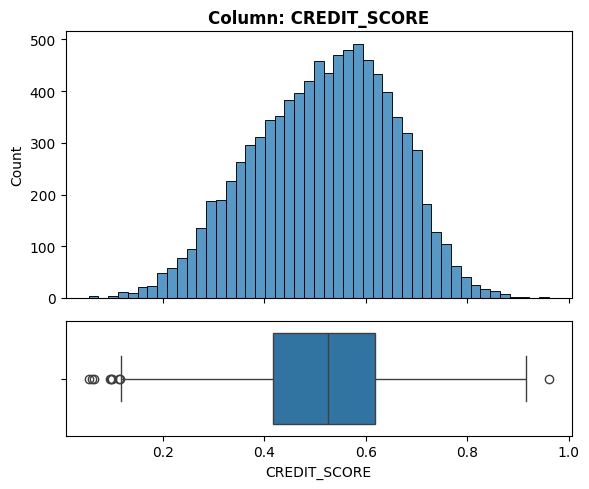

- NaN's Found: 982 (9.82%)
- Unique Values: 9018
- Most common value: 'nan' occurs 982 times (9.82%)
- Not constant or quasi-constant.


(<Figure size 600x500 with 2 Axes>,
 array([<Axes: title={'center': 'Column: CREDIT_SCORE'}, xlabel='CREDIT_SCORE', ylabel='Count'>,
        <Axes: xlabel='CREDIT_SCORE'>], dtype=object))

In [27]:
feature='CREDIT_SCORE'
explore_numeric(df, feature, figsize=(6,5))

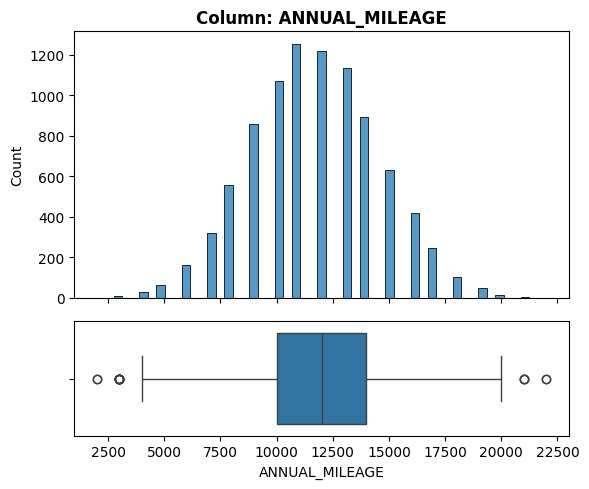

- NaN's Found: 957 (9.57%)
- Unique Values: 21
- Most common value: '11000.0' occurs 1253 times (12.53%)
- Not constant or quasi-constant.


(<Figure size 600x500 with 2 Axes>,
 array([<Axes: title={'center': 'Column: ANNUAL_MILEAGE'}, xlabel='ANNUAL_MILEAGE', ylabel='Count'>,
        <Axes: xlabel='ANNUAL_MILEAGE'>], dtype=object))

In [28]:
feature='ANNUAL_MILEAGE'

explore_numeric(df, feature, figsize=(6,5))

- Choose a model
- Preprocess data
- Fit and evaluate a default model
- Extract and visualize the top 10 features using permutation importance (from Intro to ML Week 4)
- Add your observations in a Markdown: Do these features make sense based on the business case?

- Create Explanatory Visualizations for the most important features.
- Select 2 out of the top 10 features from your permutation importances and produce explanatory visualizations showing the relationship between the feature and the target.
- The purpose is to demonstrate key trends you found that will be of interest to a stakeholder.
1. These visuals should be reporting-quality with titles, labels, and a short explanation of the trend. Be sure to explain in a text cell the insight associated with each visual. Both of these visualizations should be easily understood by a non-technical audience (Neither of these should be histograms, boxplots, or correlation plots).